In [209]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize
import os
from tqdm import tqdm
import glob
from glob import glob
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
%matplotlib inline

In [157]:
train_dir = "/opt/ml/input/data/train/"

In [158]:
data = pd.read_csv(os.path.join(train_dir, 'train.csv'))
image_dir = os.path.join(train_dir,'images')

print(image_dir)
print(data.dtypes)

/opt/ml/input/data/train/images
id        object
gender    object
race      object
age        int64
path      object
dtype: object


In [159]:
data.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [160]:
image_dirs=[]
for img_path in data.path:
    image_dirs.append(image_dir+'/'+ img_path+'/')

print(image_dirs[0])

/opt/ml/input/data/train/images/000001_female_Asian_45/


In [161]:
image_paths=[]

for i_dir in image_dirs:
    image_paths.append(glob.glob(f'{i_dir}/**'))

tf = torchvision.transforms.ToTensor()
cnt=0

dataset_path=[]
dataset_label=[]

for img_path in image_paths:
    for image in img_path:
        dataset_path.append(image)
        if 'normal' in image:
            cnt+=1
            dataset_label.append(2)
        elif 'incorrect' in image:
            dataset_label.append(1)
        else:
            dataset_label.append(0)
            
        #img = PIL.Image.open(image)
        #plt.imshow(img)
        #plt.show()
        #img_t = tf(img)
        #print(img_t.size(), img_t[0][0][0]+img_t[1][0][0]+img_t[2][0][0])
        

In [162]:
cnt

2700

In [163]:
class TrainDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image = PIL.Image.open(self.img_paths[index])
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return len(self.img_paths)

In [176]:
transform = torchvision.transforms.Compose([Resize((512,384), PIL.Image.BILINEAR), ToTensor(), Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),])
dataset = TrainDataset(dataset_path, transform)

loader = DataLoader(dataset, shuffle=False)

In [177]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [166]:
f = open(train_dir+"/isthisright.csv","w")
f.write("ImageID"+','+ "ans"+"\n")
for i in range(len(dataset_path)):
    f.write(dataset_path[i]+','+str(dataset_label[i])+'\n')
f.close()

In [167]:
submission = pd.read_csv(os.path.join(train_dir, 'isthisright.csv'))                                      

In [170]:
device = torch.device('cuda')
model = MyModel(num_classes=18).to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

submission.to_csv(os.path.join(train_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


## EDA Code



In [192]:
class cfg:
    data_dir = "/opt/ml/input/data/train/"
    img_dir = f"{data_dir}/images"
    df_path = f"{data_dir}/train.csv"

In [193]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [194]:
def get_ext(img_dir, img_id):
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    
    return ext

In [211]:
def get_img_stats(img_dir, img_ids):
    
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir,img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [212]:
img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

100%|██████████| 100/100 [00:14<00:00,  6.72it/s]

Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.55800916 0.51224077 0.47767341]
RGB Standard Deviation: [0.21817792 0.23804603 0.25183411]


In [213]:
import cv2
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [220]:
imgs = []
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)

for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
    imgs.append(img)

imgs = np.array(imgs)

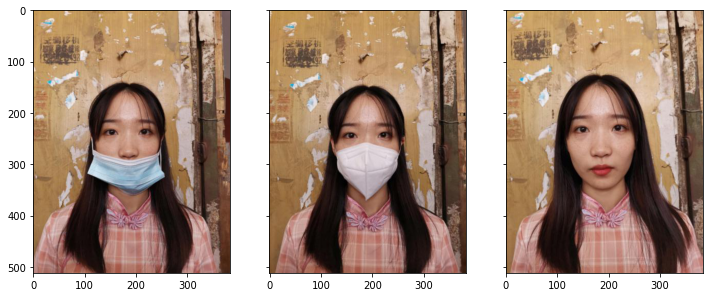

In [222]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,6))

axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[-1])
plt.show()

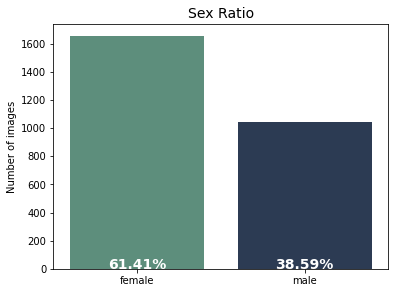

In [226]:
import seaborn as sns

plt.figure(figsize=(6, 4.5))
ax = sns.countplot(x = 'gender', data = df, palette=["#55967e", "#263959"])

plt.xticks(np.arange(2), ['female', 'male'])
plt.title('Sex Ratio', fontsize=14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = df['gender'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]

for i,v in enumerate(counts_pct):
    ax.text(i,0,v,horizontalalignment = 'center', size=14, color='w', fontweight='bold')
    
plt.show()

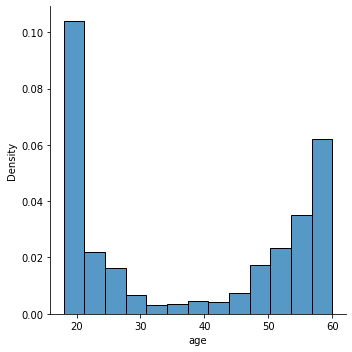

In [229]:
sns.displot(df, x="age", stat="density")
plt.show()

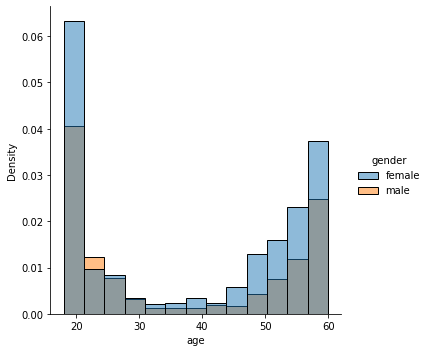

In [231]:
sns.displot(df,x="age", hue="gender", stat="density")
plt.show()

In [232]:
df['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

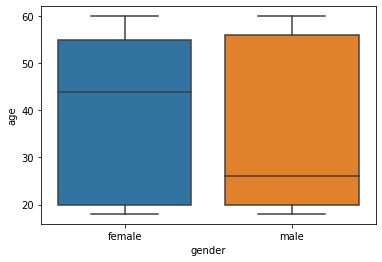

In [234]:
sns.boxplot(x='gender', y='age', data=df)
plt.show()

In [235]:
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)

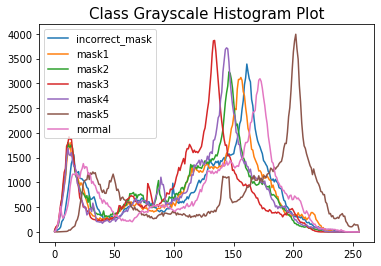

In [239]:
plt.figure()
plt.subplot(111)

for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0,255))
    sns.lineplot(data=histogram)
    
plt.legend(num2class)
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

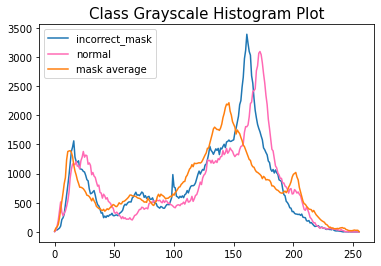

In [240]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color='hotpink')

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, num2class[i]+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0))

plt.legend(['incorrect_mask', 'normal', 'mask average'])
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

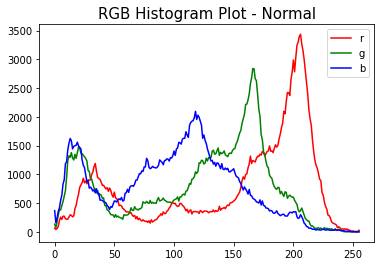

In [242]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)))
colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend(['r','g','b'])
plt.title('RGB Histogram Plot - Normal', fontsize=15)
plt.show()

In [248]:
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [249]:
imgs = []
bboxes = []
not_found_idx = []
img_id = df.iloc[504].path
ext = get_ext(cfg.img_dir, img_id)
for i, class_id in enumerate(num2class):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
    bbox = face_cascade.detectMultiScale(img)
    imgs.append(img)
    if len(bbox) != 0:
        bboxes.append(bbox.max(axis=0))
    else:
        not_found_idx.append(i)
        print(f'{class_id} not found face')
imgs = np.array(imgs)
bboxes = np.array(bboxes)

incorrect_mask not found face
mask1 not found face
mask5 not found face


In [250]:
def plot_raw_images(img_dir, img_id):
    ext = get_ext(img_dir, img_id)
    img = np.array(Image.open(os.path.join(img_dir, img_id, 'normal' + ext)))
    
    plt.figure(figsize=(6,6))
    plt.imshow(img)

In [251]:
def show_from_id(idx):
    img_id = df.iloc[idx].path
    gen = df.iloc[idx].gender
    age = df.iloc[idx].age
    plot_raw_images(cfg.img_dir, img_id)
    plt.title(f'{gen} {age}')
    plt.show()

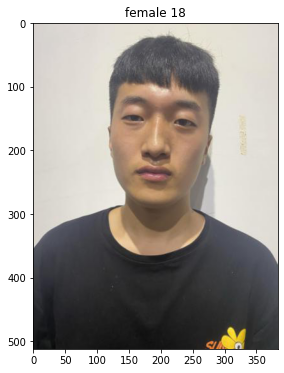

In [252]:
show_from_id(2399)

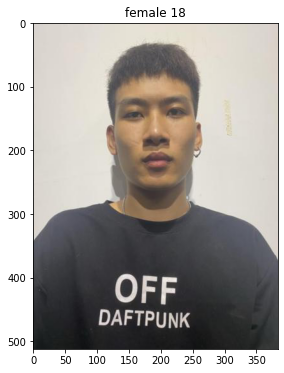

In [253]:
show_from_id(2400)

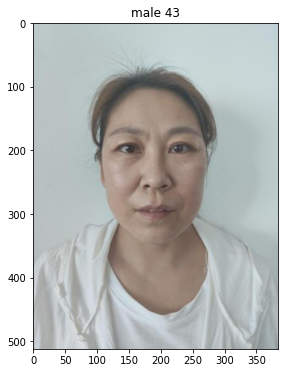

In [254]:
show_from_id(1912)

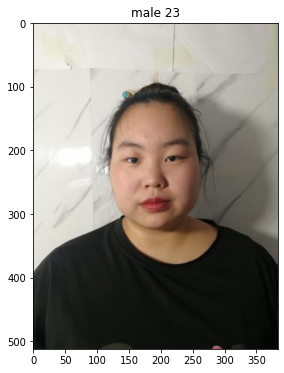

In [255]:
show_from_id(764)

In [256]:
def plot_mask_images(img_dir, img_id):
    """
    마스크 정상착용 5장과 이상하게 착용한 1장을 2x3의 격자에 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    """
    ext = get_ext(img_dir, img_id)
    imgs = [np.array(Image.open(os.path.join(img_dir, img_id, class_name + ext))) for class_name in num2class[:-1]]
    
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(15, 12))
    for i in range(n_rows*n_cols):
        axes[i//(n_rows+1)][i%n_cols].imshow(imgs[i])
        axes[i//(n_rows+1)][i%n_cols].set_title(f'{num2class[i]}', color='r')
    plt.tight_layout()
    plt.show()

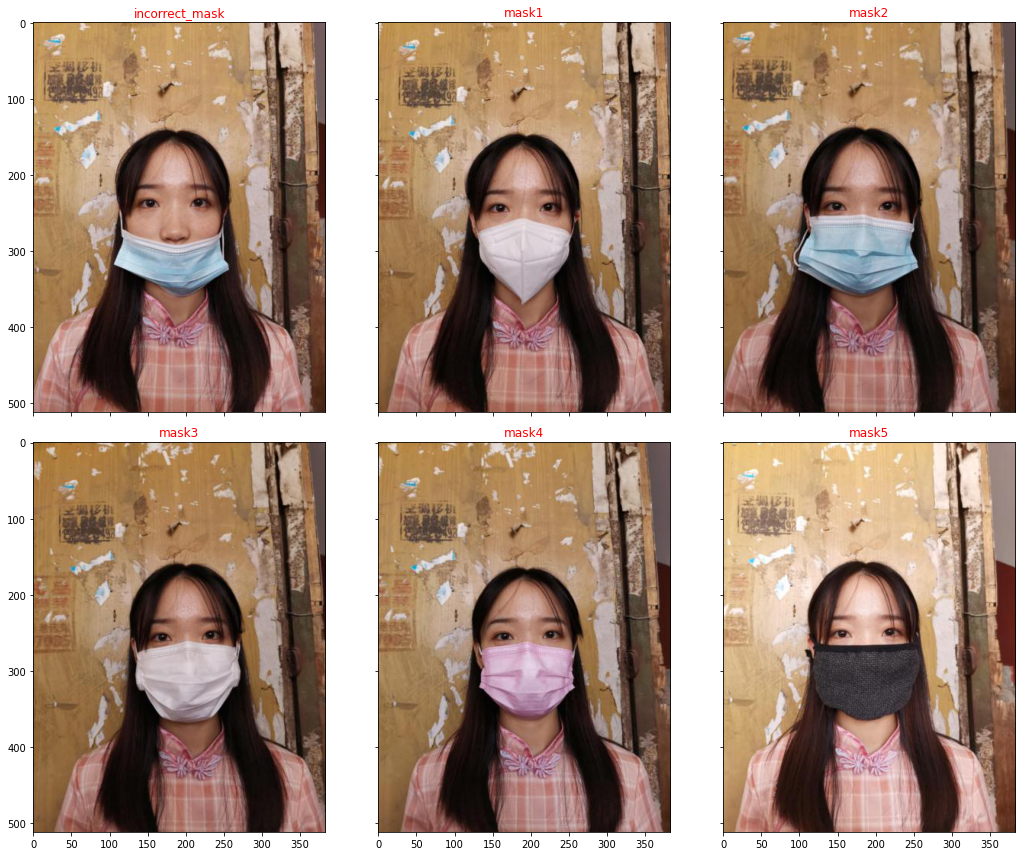

In [257]:
idx = 500
img_id = df.iloc[idx].path
plot_mask_images(cfg.img_dir, img_id)